# Random Forest

Random forests have gained huge popularity in applications of machine learning during the last decade due to their good classification performance, scalability, and ease of use. Intuitively, a random forest can be considered as an ensemble of decision trees. 

The idea behind a random forest is to average multiple (deep) decision trees that individually suffer from high variance, to build a more robust model that has a better generalization performance and is less susceptible to overfitting.

## Steps to build Random Forest 

* Draw a random bootstrap sample of size n (randomly choose n samples from the training set with replacement)

* Grow a decision tree from the bootstrap sample. At each node:
    * Randomly select d features without replacement
    * Split the node using the feature that provides the best split according to the objective function, for instance, maximizing the information gain
    

* Repeat the steps 1-2 k times

* Aggregate the prediction by each tree to assign the class label by majority vote
    

Although random forests don't offer the same level of interpretability as decision trees, a big advantage of random forests is that we don't have to worry so much about choosing good hyperparameter values. We typically don't need to prune the random forest since the ensemble model is quite robust to noise from the individual decision trees

Each of our classifiers will learn different instances (with some overlap) with different features, which creates a less correlated but generalized predictor.

In [73]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data 

In [87]:
df=pd.read_csv('Fraud_Data.csv')

In [88]:
df.shape

(151112, 10)

In [89]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class
0,22058,2/24/15 22:55,4/18/15 2:47,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0
1,333320,6/7/15 20:39,6/8/15 1:38,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0
2,1359,1/1/15 18:52,1/1/15 18:52,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 10 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
class             151112 non-null int64
dtypes: int64(4), object(6)
memory usage: 11.5+ MB


## EDA 

In [91]:
#confirm if we have multiple records for any user id
len(df.user_id.unique())

151112

In [92]:
#check for class skewness
df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [93]:
#groupby fraud class
df.groupby('class').mean()

,user_id,purchase_value,age
class,,,
0,200098.920123,36.929418,33.122356
1,200869.065366,36.993004,33.318281


People who doing fraudulent transcations seems to be on higher side in terms of age

In [94]:
#groupby browser used
df.groupby('browser').mean()

,user_id,purchase_value,age,class
browser,,,,
Chrome,200687.687248,37.031775,33.126921,0.098792
FireFox,200641.932466,36.846485,33.125640,0.095165
IE,199088.138890,36.815177,33.169467,0.086775
Opera,201405.358542,36.551959,32.679543,0.089227
Safari,199842.956460,37.020067,33.215957,0.090201


People who doing fraudulent transcations seems to be using chrome more often

In [95]:
#groupby sex variable
df.groupby('sex').mean()

,user_id,purchase_value,age,class
sex,,,,
F,200154.199764,36.892023,33.098887,0.091007
M,200183.023207,36.966215,33.170455,0.095523


### Data Preprocessing 

In [96]:
from datetime import datetime
#convert the date column from object to datetime stamp
# %y is required instead of %Y ( 2 digit year representation vs 4 digit year )
df['signup_time'] =  pd.to_datetime(df['signup_time'], format="%m/%d/%y %H:%M")

df['purchase_time'] =  pd.to_datetime(df['purchase_time'], format="%m/%d/%y %H:%M")


In [97]:
#validate the datatype for time columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 10 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
class             151112 non-null int64
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 11.5+ MB


In [98]:
#validate the remaining columns
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'class'],
      dtype='object')

### Break Up Dates And Times Into Individual Features

In [99]:
# Create features for year, month, day, hour, and minute
df['signup_year'] = df['signup_time'].dt.year
df['signup_month'] = df['signup_time'].dt.month
df['signup_month'] = df['signup_time'].dt.dayofweek
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour
df['signup_minute'] = df['signup_time'].dt.minute
df['purchase_year'] = df['purchase_time'].dt.year
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_month'] = df['purchase_time'].dt.dayofweek
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour
df['purchase_minute'] = df['purchase_time'].dt.minute

In [100]:
## calculating time difference between sign up and purchase
df['date_difference']=(df['purchase_time']-df['signup_time']).dt.days

In [101]:
# removing user_id, signup_time,purchase_time columns
del df['user_id']
del df['device_id']
del df['signup_time']
del df['purchase_time']

In [102]:
df.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'class',
       'signup_year', 'signup_month', 'signup_day', 'signup_hour',
       'signup_minute', 'purchase_year', 'purchase_month', 'purchase_day',
       'purchase_hour', 'purchase_minute', 'date_difference'],
      dtype='object')

In [103]:
df.head(3)

,purchase_value,source,browser,sex,age,class,signup_year,signup_month,signup_day,signup_hour,signup_minute,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_minute,date_difference
0,34,SEO,Chrome,M,39,0,2015,1,24,22,55,2015,5,18,2,47,52
1,16,Ads,Chrome,F,53,0,2015,6,7,20,39,2015,0,8,1,38,0
2,15,SEO,Opera,M,53,1,2015,3,1,18,52,2015,3,1,18,52,0


### Dummification 

In [104]:
df_new=pd.get_dummies(df,columns=['source','browser','sex'])

In [105]:
df_new.columns

Index(['purchase_value', 'age', 'class', 'signup_year', 'signup_month',
       'signup_day', 'signup_hour', 'signup_minute', 'purchase_year',
       'purchase_month', 'purchase_day', 'purchase_hour', 'purchase_minute',
       'date_difference', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M'],
      dtype='object')

In [69]:
df_new.shape

(151112, 24)

### Input/Output Data 

In [106]:
#import model specific libraries
from sklearn.model_selection import train_test_split

#create input dataset without including target variable( class column)
X=df_new.loc[:, df_new.columns != 'class']

In [107]:
#Validate the shape of input data X
X.shape

(151112, 23)

In [110]:
#Create the target data with only class column
y=df_new['class']
#Validate the shape of output data y
y.shape

(151112,)

#### Train Test split 

In [111]:
#Split the data into training and test data (70/30 ratio)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=100, stratify=y)

In [112]:
#validate the shape of train and test dataset
print (X_train.shape)
print (y_train.shape)

print (X_test.shape)
print (y_test.shape)

(105778, 23)
(105778,)
(45334, 23)
(45334,)


In [113]:
#check on number of positive classes in train and test data set
print(np.sum(y_train))
print(np.sum(y_test))

9906
4245


### Model Building & Training 

In [114]:
#import the randomforest classifier
from sklearn.ensemble import RandomForestClassifier

In [115]:
#Train the random forest classifier on training dataset
rf = RandomForestClassifier().fit(X_train,y_train)

In [128]:
# Model details and parameters
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
#validate the model performance on unseen data
rf.score(X_test, y_test)

0.95522124674637132

In [117]:
#make predictions on unseen data
predictions=rf.predict(X_test)

## Results 

In [119]:
#import confusion matrix , classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


### Confusion Matrix 

In [127]:
print(confusion_matrix(y_test, predictions))

[[41034    55]
 [ 1975  2270]]


### Classification Report 

In [120]:
print(classification_report(y_test, predictions,target_names=["Genuine", "Fraud"]))

             precision    recall  f1-score   support

    Genuine       0.95      1.00      0.98     41089
      Fraud       0.98      0.53      0.69      4245

avg / total       0.96      0.96      0.95     45334



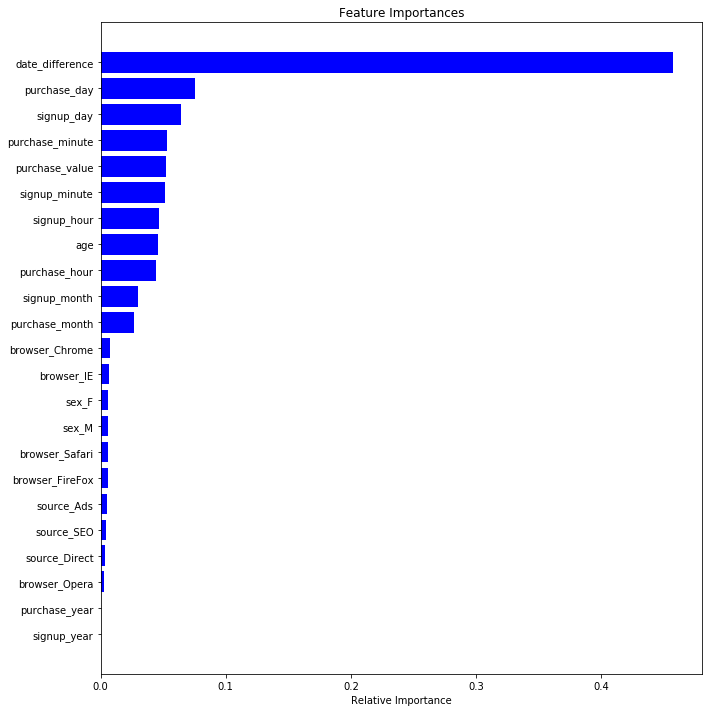

In [136]:
## Feature Importance 
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## Hyperparameter Tunning

* rf.criterion: This is the criterion for how the splits are determined. The default is gini
* rf.bootstrap: A Boolean that indicates whether we used bootstrap samples when training random forest
* rf.n_jobs: The number of jobs to train and predict. If you want to use all the processors, set this to -1
* rf.max_features: This denotes the number of features to consider when making the best split
* rf.compute_importances: This helps us decide whether to compute the importance of the features
* rf.max_depth: This denotes how deep each tree can go